PROJECT DEFINITION:

We have created a regression model using Ensemble Learning's model XGBoost particularly the XGBoostRegressor to predict the "CALORIES BURNT DURING EXERCISE".
The main feature of this project is the feature engineering done to increase the importance of the features that have been added to an existing dataset from Kaggle.

For eg: We have ordered the seasons such that during label encoding: "winter" which is the most favourable season to burn calories is assigned 4 which is taken into consideration when we have feature engineered a Custom MET Value assigning weights based on research to each feature.

In [1]:
#IMPORT LIBRARIES

import pandas as pd                                                              #for data manipulation 
from sklearn.preprocessing import LabelEncoder                                   #for encoding categorical variables
from sklearn.model_selection import train_test_split                             #for splitting data into training and testing sets
from xgboost import XGBRegressor                                                 #for XGBoost regression mode
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score    #for evaluating model performance
import matplotlib.pyplot as plt                                                  #for plotting graphs


%matplotlib inline

In [ ]:
#LOAD DATASET

df1=pd.read_csv('calories.csv')
df2=pd.read_csv('exercise_met.csv')
df1.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [ ]:
df2.head()

,Exercise_Type,Light Intensity,Moderate Intensity,High Intensity
0,Running,4.90,9.8,14.70
1,Walking,1.75,3.5,5.25
2,Jogging,3.50,7.0,10.50
3,Cycling (Outdoor),4.00,8.0,12.00
4,Cycling (Indoor),3.50,7.0,10.50


In [ ]:
#FEATURE ENGINEERING 

from random import choices,randint,seed,choice 

#Creating new features: 'Exercises', 'Calories Consumed', 'Season'
for i in range(len(df1)):
    seed(i)
    a=randint(1,5)
    selected_exercises=choices(df2['Exercise_Type'].tolist(),k=a)
    df1.loc[i,'Exercises']=', '.join(selected_exercises)
    b=randint(200,4000)
    df1.loc[i,'Calories Consumed']=b
    seasons=['Summer', 'Monsoon', 'Spring', 'Autumn', 'Winter']
    df1.loc[i,'Season']=choice(seasons)

# max_heart_rate=220-age

#Calculating 'MET Value' based on 'Heart Rate','Age' 'Exercises'
df1['MET_Value']=df1.apply(lambda row: df2[df2['Exercise_Type'].isin(row['Exercises'].split(', '))]['Light Intensity'].mean() 
                    if row['Heart_Rate']<=0.6*(220-row['Age']) else df2[df2['Exercise_Type'].isin(row['Exercises'].split(', '))]['Moderate Intensity'].mean()
                    if 0.6*(220-row['Age'])<row['Heart_Rate']<=0.7*(220-row['Age']) else df2[df2['Exercise_Type'].isin(row['Exercises'].split(', '))]['High Intensity'].mean()
                    if row['Heart_Rate']>0.7*(220-row['Heart_Rate']) else f' ', axis=1)

df1.head()


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Exercises,Calories Consumed,Season,MET_Value
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,"Battle Ropes, T-Bar Rows, Barbell Squats, Over...",1858.0,Spring,5.875
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,"Crunches, Stretching",458.0,Spring,1.625
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,Elliptical,1678.0,Monsoon,2.500
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,"Plank, Zumba",3951.0,Winter,2.200
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,"Romanian Deadlifts, Speed Skaters",2161.0,Monsoon,3.200


In [ ]:
# TUNING FEATURE IMPORTANCE

#Encoding 'Season' and 'Exercises' using Label Encoding

le_gender=LabelEncoder()
le_season=LabelEncoder()
df1['Gender']=le_gender.fit_transform(df1['Gender'])
df1['Season']=le_season.fit_transform(df1['Season']) #Here we use label encoding for simplicity and give weight to each season, but one-hot encoding could also be used as we are using XGBoost.

#Attempt to feature engineer the importance of the features in the model

gender_norm= df1['Gender']
temp_norm = (df1['Body_Temp'] - 37)
calories_norm = (df1['Calories Consumed']/2000)       
season_norm = df1['Season']

df1['Calories'] = ( df1['MET_Value'] * (1 + 0.05*gender_norm + 0.06*temp_norm + 0.05*calories_norm + 0.04*season_norm) * df1['Weight'] * (df1['Duration'] / 60))
df1.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Exercises,Calories Consumed,Season,MET_Value
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,374.876964,"Battle Ropes, T-Bar Rows, Barbell Squats, Over...",1858.0,2,5.875
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,29.334987,"Crunches, Stretching",458.0,2,1.625
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,20.308760,Elliptical,1678.0,1,2.500
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,49.708242,"Plank, Zumba",3951.0,4,2.200
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,39.038640,"Romanian Deadlifts, Speed Skaters",2161.0,1,3.200


In [ ]:
#SPLIT DATASET

#Defining input features and target variable

features=['MET_Value','Gender','Body_Temp','Calories Consumed','Season','Weight','Duration']
   

x = df1[features]       #Setting Input Features
y = df1['Calories']     #Setting Target Variable

#Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)  



In [ ]:
#TRAIN MODEL

model=XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)      #Initialize the model
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Text(0.5, 1.0, 'Mean Absolute Error: 3.04 \n Mean Squared Error: 43.24 \n R-squared: 1.00')

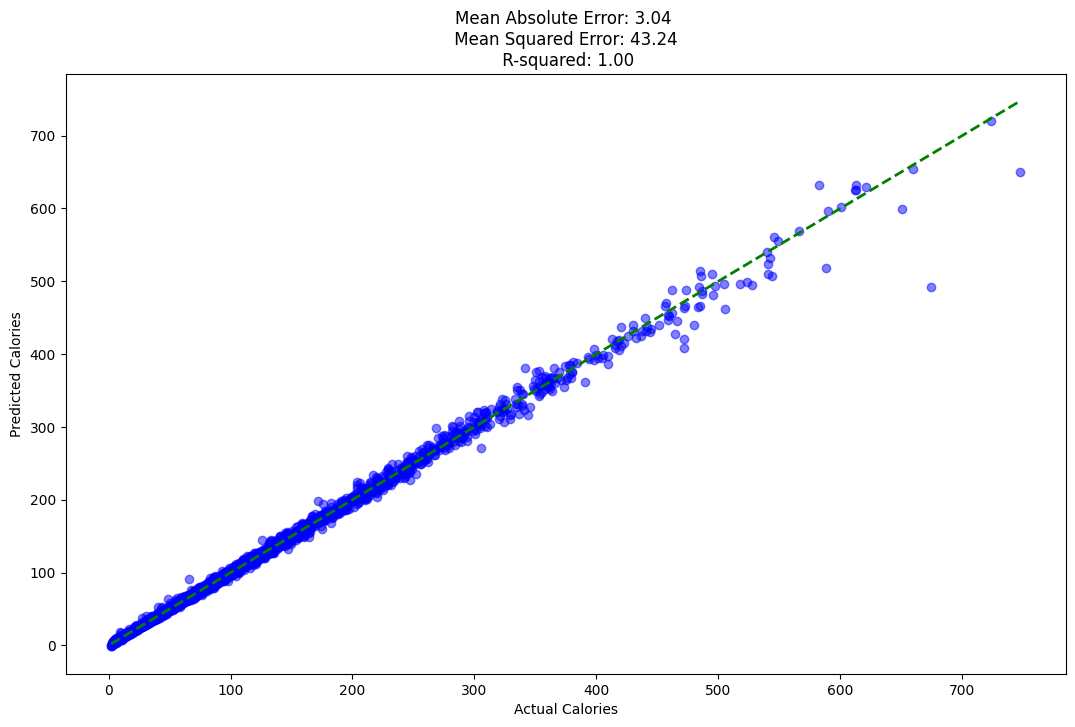

In [ ]:
#MAKE PREDICTIONS AND EVALUATE THE MODEL

#Predictions on the test set
y_pred=model.predict(x_test)                 #predictions on the test set

#Evaluating metrics
mae=mean_absolute_error(y_test, y_pred)      #Mean Absolute Error
mse=mean_squared_error(y_test, y_pred)       #Mean Squared Error
r2=r2_score(y_test, y_pred)                  #R-squared score

#Plotting the test vs predicted values
fig =plt.figure(figsize=(10, 6))
axes=fig.add_axes([0, 0, 1, 1])

axes.scatter(y_test, y_pred, color='blue', alpha=0.5)
axes.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2)  # from the (min,min) point to the (max,max) point
axes.set_xlabel('Actual Calories')
axes.set_ylabel('Predicted Calories')
axes.set_title(f'Mean Absolute Error: {mae:.2f} \n Mean Squared Error: {mse:.2f} \n R-squared: {r2:.2f}')


Feature Importance: [0.491918   0.05396887 0.00693283 0.00260565 0.00780436 0.08772308
 0.3490472 ]


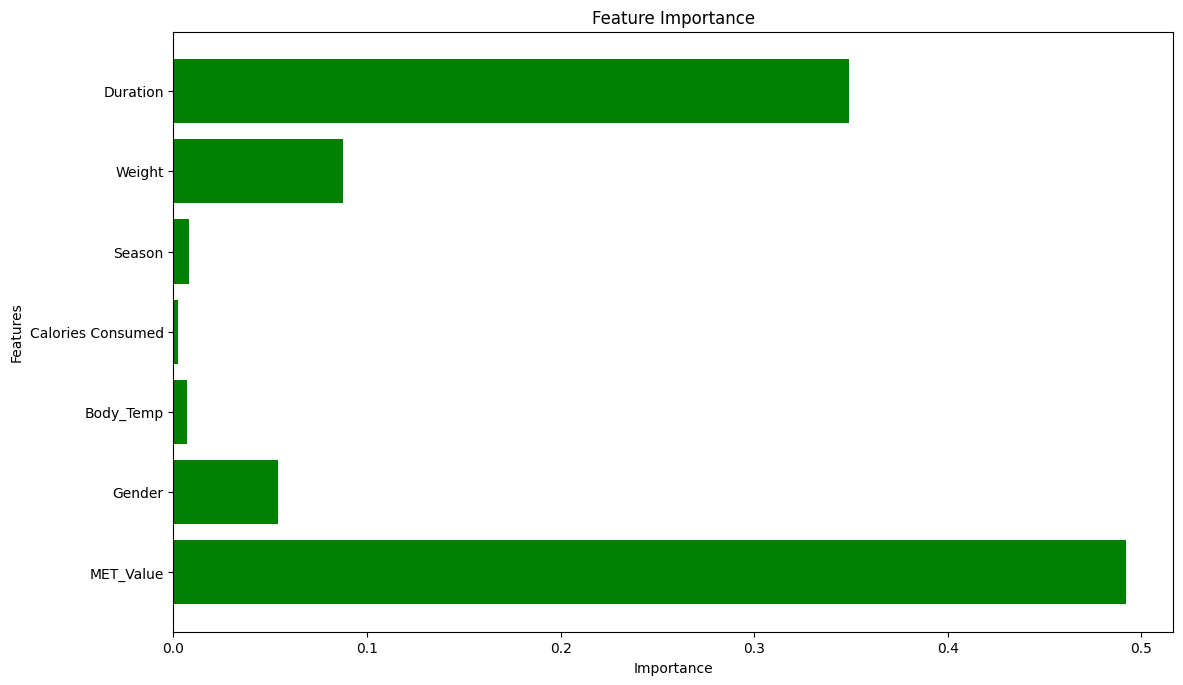

In [ ]:
#PLOT FEATURE IMPORTANCE

importance=model.feature_importances_               #Get feature importance

#Creating a plot for the feature importance
fig1=plt.figure(figsize=(10, 6))
features=x.columns
axes1=fig1.add_axes([0.5, 0, 1, 1])
axes1.barh(features, importance, color='green')
axes1.set_xlabel('Importance')
axes1.set_ylabel('Features')
axes1.set_title('Feature Importance')
print("Feature Importance:", importance)


In [ ]:
#TAKING USER INPUT

user_gender = input("Gender (male/female): ").strip().lower()
user_age = int(input("Age: "))
user_height = int(input("Height (cm): "))
user_weight = float(input("Weight (kg): "))
user_duration = float(input("Duration (minutes): "))
user_heart_rate = int(input("Heart Rate (bpm): "))

# For user to select the exercises
print("\nAvailable Exercises:")
exercise_list = sorted(df2['Exercise_Type'].unique().tolist())                   #Converts all the elements in Exercise Type to a list that is alphabeticaly ordered
for j, name in enumerate(exercise_list):
    print(f"{j + 1}. {name}")

exercise_input = input("\nSelect exercise numbers (comma-separated): ").strip()
selected_indices = [int(i.strip()) - 1 for i in exercise_input.split(',') if i.strip().isdigit()]               #List Comprehension
selected_exercises = [exercise_list[i] for i in selected_indices if 0 <= i < len(exercise_list)]                #List Comprehension


# Compute MET_Value based on heart rate
met_values = df2[df2['Exercise_Type'].isin(selected_exercises)][['Light Intensity', 'Moderate Intensity', 'High Intensity']]

if 60 <= user_heart_rate <= 120:
    avg_met = met_values['Light Intensity'].mean()
elif 120 < user_heart_rate <= 150:
    avg_met = met_values['Moderate Intensity'].mean()
else:
    avg_met = met_values['High Intensity'].mean()

user_temp = float(input("Body Temperature (°C): "))
user_season= input("Season (Winter/Summer/Monsoon/Spring/Autumn): ").strip().capitalize()
user_meal_cal = float(input("Total Meal Calories (before workout): "))


# Preparing Input Data

input_data = {
    'Gender': le_gender.transform([user_gender])[0],
    'Age': user_age,
    'Body_Temp': user_temp,
    'Weight': user_weight,
    'Duration': user_duration,
    'Heart_Rate': user_heart_rate,
    'Calories Consumed': user_meal_cal,
    'Season': le_season.transform([user_season])[0],
    'MET_Value': avg_met
}



In [ ]:
print(f"Here are your inputs: \n" 
      f"Gender: {user_gender} \n" 
      f"Age: {user_age} years \n" 
      f"Height: {user_height} cm \n" 
      f"Weight: {user_weight} kg \n" 
      f"Exercise Duration: {user_duration} minutes \n" 
      f"Heart Rate: {user_heart_rate} bpm \n" 
      f"Exercises: {', '.join(selected_exercises)}\n" 
      f"Body Temperature: {user_temp} degree\n" 
      f"Season: {user_season}\n" 
      f"Calories Consumed before Workout: {user_meal_cal} calories \n")

Here are your inputs: 
Gender: male 
Age: 21 years 
Height: 187 cm 
Weight: 100.0 kg 
Exercise Duration: 40.0 minutes 
Heart Rate: 140 bpm 
Exercises: Swimming
Body Temperature: 35.0 degree
Season: Winter
Calories Consumed before Workout: 1000.0 calories 



In [ ]:
#USER INPUT PREDICTION

input_df = pd.DataFrame([input_data])
input_df = input_df[x.columns]  # Match training columns

predicted_calories = model.predict(input_df)[0]         # [0] To retrieve the scalar value 


print(f"\n Estimated Calories Burnt: {predicted_calories:.2f} kcal")
print(f" Based on: {', '.join(selected_exercises)}")



 Estimated Calories Burnt: 527.20 kcal
 Based on: Swimming
